In [1]:
require(tidyverse)
require(data.table)
require(ROCR)

Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0       ✔ purrr   0.3.1  
✔ tibble  2.0.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: data.table

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose

Loading required package: ROCR
Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



In [2]:
covar <- '/oak/stanford/groups/mrivas/ukbb24983/sqc/ukb24983_GWAS_covar.phe' %>%
fread(sep='\t', data.table=F)


In [3]:
GBE_ID <- 'HC276'

In [4]:
priv_out_d <- '/oak/stanford/groups/mrivas/projects/PRS/private_output'

In [5]:
sscore_f <- file.path(
    priv_out_d, 'snpnet_PRS/HC_20190303/8_score_all', 
    paste0(GBE_ID, '.sscore')    
)
sscore_df <- fread(
    cmd=paste0('cat ', sscore_f, ' | cut -f2,6'), sep='\t', data.table=F
)


In [6]:
phe_f <- paste0(
    '/oak/stanford/groups/mrivas/ukbb24983/phenotypedata/extras/highconfidenceqc/phe/',
    GBE_ID, '.phe'
)
phe_df <- fread(
    cmd=paste0('cat ', phe_f, ' | cut -f2,3'), sep='\t', data.table=F
)
colnames(phe_df) <- c('IID', 'HC382')


In [7]:
keep <- list()
for(split in c('train', 'val', 'test')){
    keep[[split]] <- file.path(
    priv_out_d, 'snpnet_PRS/HC_20190303/1_split',
    paste0(GBE_ID, '.', split)
    ) %>%
    fread(sep='\t', col.names=c('FID', 'IID')) %>% 
    select(IID) %>% mutate(split = split)
}
split_df <- keep %>% bind_rows()

In [8]:
covars_beta_f <- file.path(
    priv_out_d, 'snpnet_PRS/HC_20190303/3_snpnet', 
    paste0(GBE_ID, '.covars.tsv.gz')    
)
covars_beta_df <- fread(
    cmd=paste0('zcat ', covars_beta_f, ' | cut -f1,2'), sep='\t', data.table=F
)


In [9]:
covar_score_df <- covar %>% select(c('IID', covars_beta_df %>% select('ID') %>% pull())) %>% 
column_to_rownames('IID') %>%
as.matrix() %*% (covars_beta_df %>% column_to_rownames('ID') %>% as.matrix()) %>%
as.data.frame() %>% rownames_to_column('IID') %>% mutate(IID = as.integer(IID)) %>%
rename(covar_score = BETA)


In [10]:
combined_df <- sscore_df %>% rename(snpnet_PRS = SCORE1_AVG) %>% 
left_join(phe_df, by='IID') %>%
rename(outcome = HC382) %>% 
filter(outcome != -9) %>%
drop_na() %>%
mutate(Percentile = rank(-snpnet_PRS) / n()) %>% 
left_join(split_df, by='IID') %>%
left_join(covar_score_df, by='IID') %>%
mutate(snpnet_covar_PRS = snpnet_PRS + covar_score)


In [11]:
combined_df %>% dim()

[1] 488374      7

In [12]:
cnt_middle <- combined_df %>% 
filter(0.4 <= Percentile, Percentile <= 0.6) %>% 
count(outcome) %>% rename(n_40_60 = n)

In [13]:
cnt_middle

outcome,n_40_60
1,96298
2,1375


In [14]:
compute_or <- function(df){
    joined_df <- df %>% count(outcome) %>% inner_join(cnt_middle, by='outcome') %>% gather(bin, cnt, -outcome)
    n_TP <- .5 + joined_df %>% filter(bin == 'n', outcome == 2) %>% select(cnt) %>% pull()
    n_TN <- .5 + joined_df %>% filter(bin != 'n', outcome == 1) %>% select(cnt) %>% pull()
    n_FP <- .5 + joined_df %>% filter(bin != 'n', outcome == 2) %>% select(cnt) %>% pull()
    n_FN <- .5 + joined_df %>% filter(bin == 'n', outcome == 1) %>% select(cnt) %>% pull()
    or <- (n_TP * n_TN) / (n_FP * n_FN)
    lor <- log(or)
    se_lor <- sqrt((1/n_TP) + (1/n_TN) + (1/n_FP) + (1/n_FN))
    OR_l <- exp(lor - 1.96 * se_lor)
    OR_u <- exp(lor + 1.96 * se_lor)
    c(or, OR_l, OR_u, n_TP / (n_TP + n_FN), n_TP, n_FN)
#     %>% print()    
}

In [15]:
compute_or_wrapper <- function(idx, df){
    bin_u = 1 - idx * 0.1
    bin_l = 1 - (idx + 1) * 0.1
    c(
        1 - bin_u, 1 - bin_l, 
        df %>% filter(bin_l < Percentile, Percentile <= bin_u) 
        %>% compute_or()
    )    
}

In [16]:
res <- lapply(0:9, compute_or_wrapper, combined_df)

In [17]:
df <- as.data.frame(res) 
colnames(df) <- lapply(0:9, function(x){x * 10 + 5})
rownames(df) <- c(
    'l', 'u', 'OR', 'OR_l', 'OR_u', 
    'Prevalence', 
    'n_cases', 'n_conts'
)
dff <- df %>%
rownames_to_column('id')

In [18]:
dff %>% fwrite(paste0(GBE_ID, '.csv'), col.names=T)

In [19]:
dff

id,5,15,25,35,45,55,65,75,85,95
l,0.000000e+00,1.000000e-01,2.000000e-01,3.000000e-01,4.000000e-01,5.000000e-01,6.000000e-01,7.000000e-01,8.000000e-01,9.000000e-01
u,1.000000e-01,2.000000e-01,3.000000e-01,4.000000e-01,5.000000e-01,6.000000e-01,7.000000e-01,8.000000e-01,9.000000e-01,1.000000e+00
OR,4.697289e-01,5.788682e-01,6.693237e-01,7.732248e-01,9.568490e-01,1.043924e+00,1.231851e+00,1.482127e+00,1.860856e+00,3.617441e+00
OR_l,4.160702e-01,5.176261e-01,6.020564e-01,6.992485e-01,8.714196e-01,9.531955e-01,1.129908e+00,1.365581e+00,1.722695e+00,3.382321e+00
OR_u,5.303078e-01,6.473561e-01,7.441068e-01,8.550273e-01,1.050653e+00,1.143288e+00,1.342991e+00,1.608619e+00,2.010096e+00,3.868906e+00
Prevalence,6.664756e-03,8.200582e-03,9.469891e-03,1.092387e-02,1.348308e-02,1.469203e-02,1.729115e-02,2.073138e-02,2.589172e-02,4.913182e-02
n_cases,3.255000e+02,4.005000e+02,4.625000e+02,5.335000e+02,6.585000e+02,7.175000e+02,8.445000e+02,1.012500e+03,1.264500e+03,2.399500e+03
n_conts,4.851350e+04,4.843750e+04,4.837650e+04,4.830450e+04,4.818050e+04,4.811850e+04,4.799550e+04,4.782650e+04,4.757350e+04,4.643850e+04


In [20]:
pred_ROCR <- list()
auc_ROCR_obj <- list()
auc_ROCR <- list()
for(feature in c('snpnet_PRS', 'covar_score', 'snpnet_covar_PRS')){
    pred_ROCR[[feature]] <- prediction(
        combined_df %>% filter(split == 'test') %>% select(feature) %>% pull(), 
        combined_df %>% filter(split == 'test') %>% select(outcome) %>% pull()
    )
    auc_ROCR_obj[[feature]] <- performance(pred_ROCR[[feature]], measure = "auc")
    auc_ROCR[[feature]] <- (auc_ROCR_obj[[feature]])@y.values[[1]]
}


In [21]:
auc_ROCR

$snpnet_PRS
[1] 0.5752323

$covar_score
[1] 0.6829101

$snpnet_covar_PRS
[1] 0.6829169

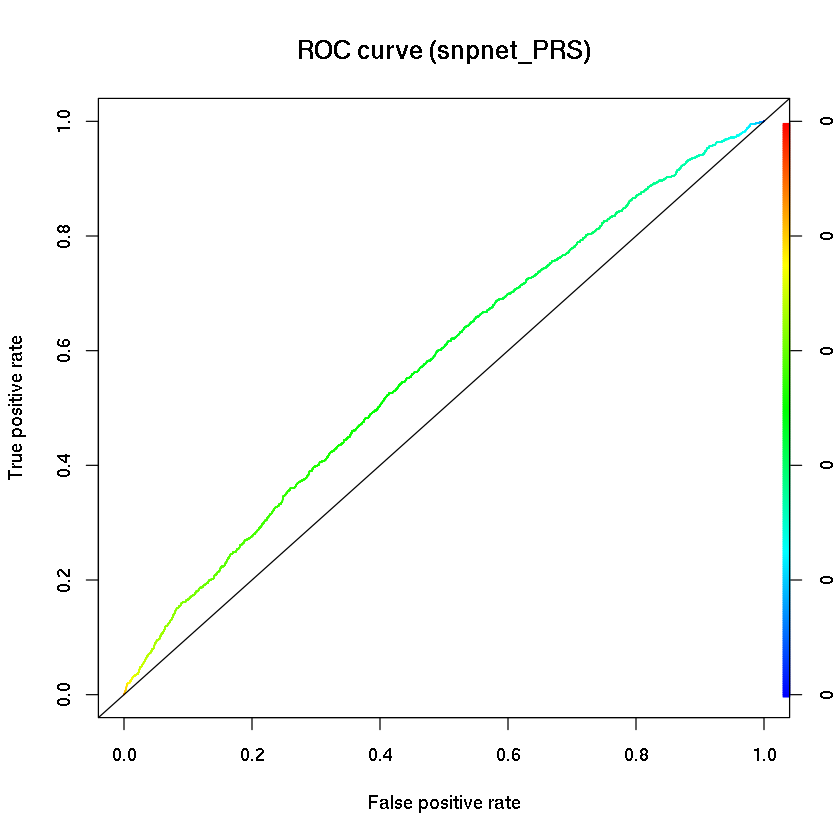

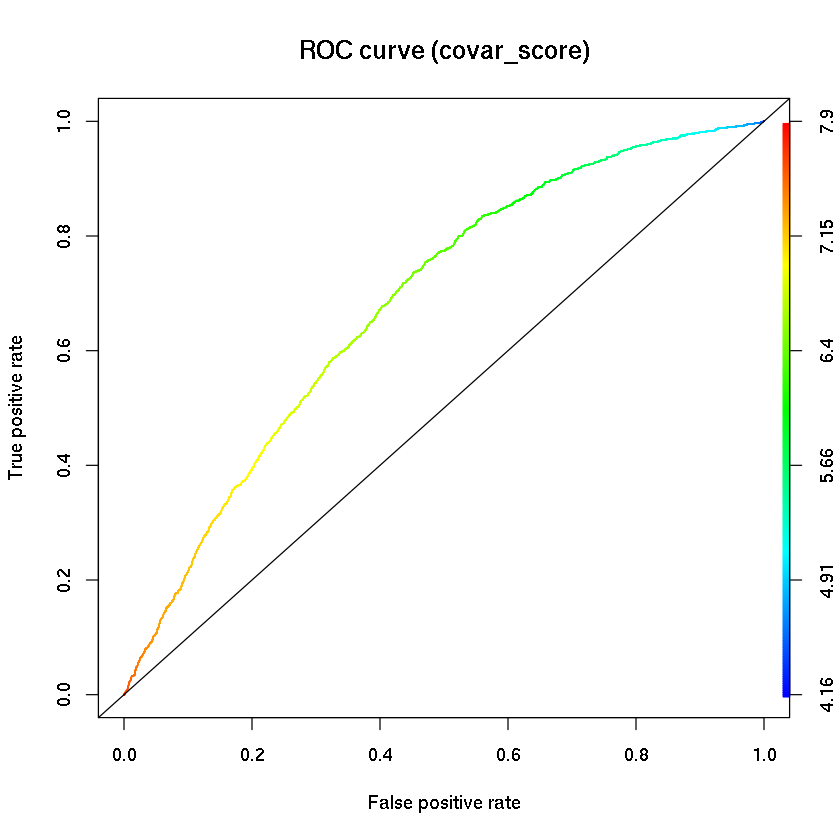

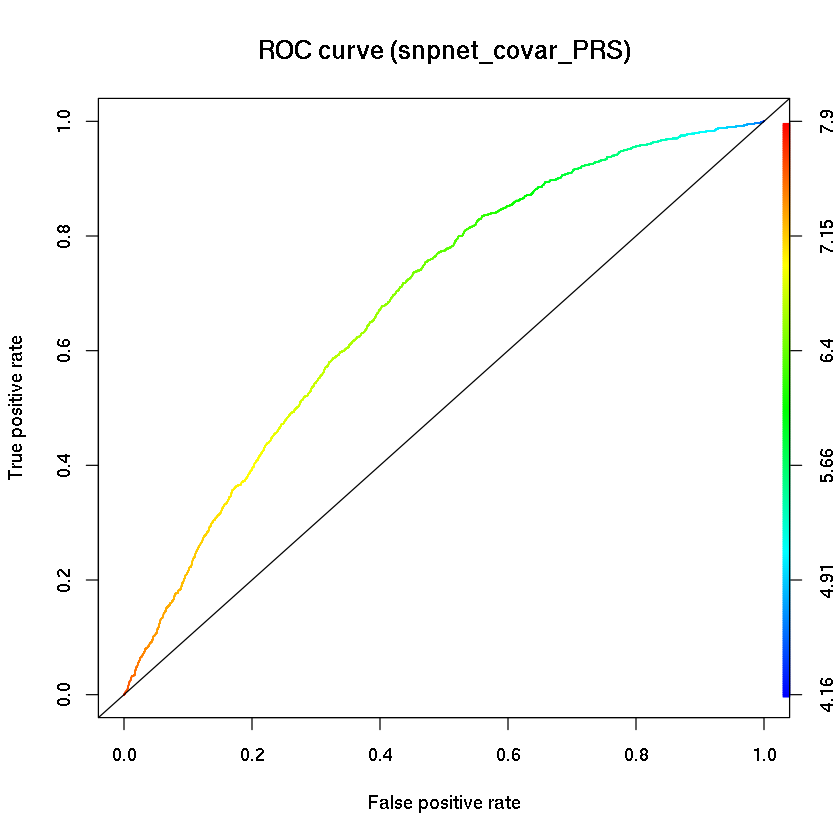

In [22]:
for(feature in c('snpnet_PRS', 'covar_score', 'snpnet_covar_PRS')){
    plot(
        performance(pred_ROCR[[feature]], measure = "tpr", x.measure = "fpr"),
        main = paste0('ROC curve (', feature, ')'), colorize = T
    )
    abline(a = 0, b = 1)
}
